# Google Store Ecommerce Data + Fake Retail Data

In this notebook, let's see one of the easiest ways of forecasting quantities with different regression models.

# Importing required libraries 

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from datetime import date 
import holidays 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

Reading CSV files 

In [19]:
marketing_spent = pd.read_csv('../Kaggle_datasets/Google_Store_Ecommerce_Data/Marketing_Spend.csv')
online = pd.read_csv('../Kaggle_datasets/Google_Store_Ecommerce_Data/Online.csv')

In [20]:
marketing_spent.head(2)

,Unnamed: 0,Offline Spend,Online Spend
0,2017-01-01,4500,2424.50
1,2017-01-02,4500,3480.36


In [21]:
online.head(2)

,Transaction ID,Date,Product SKU,Product,Product Category (Enhanced E-commerce),Quantity,Avg. Price,Revenue,Tax,Delivery
0,48497,20171231,GGOENEBQ079099,Nest® Protect Smoke + CO White Battery Alarm-USA,Nest-USA,4.0,80.52,316.0,34.44,19.99
1,48496,20171231,GGOENEBQ079199,Nest® Protect Smoke + CO White Wired Alarm-USA,Nest-USA,5.0,80.52,395.0,33.14,6.50




1. Renaming columns as the Date column in names as "Unnamed" in marketing_spent csv file.
2. Changing Date format in online csv file from YYYYMMDD to YYYY-MM-DD.

In [22]:
marketing_spent.rename(columns = {'Unnamed: 0':'Date'}, inplace = True) 
marketing_spent['Date']= pd.to_datetime(marketing_spent['Date'])
online['Date'] = pd.to_datetime(online['Date'], format='%Y%m%d')

understanding Online dataset

In [23]:
# understanding marketing spent dataset
print("Total number of rows:",online.shape[0])
print("Total number of colums:",online.shape[1])
print("\n\nList of columns:", online.columns.tolist())
print("\n\nMin Date:", online['Date'].min())
print("Max Date:", online['Date'].max())
print("\n\nDatatypes:\n",online.dtypes)
print("\n\nUnique values:\n",online.nunique())
print("\n\nMissing values:\n",online.isnull().sum())
print("\n\nQuantitative analysis\n", online.describe())

Total number of rows: 54144
Total number of colums: 10


List of columns: ['Transaction ID', 'Date', 'Product SKU', 'Product', 'Product Category (Enhanced E-commerce)', 'Quantity', 'Avg. Price', 'Revenue', 'Tax', 'Delivery']


Min Date: 2017-01-01 00:00:00
Max Date: 2017-12-31 00:00:00


Datatypes:
 Transaction ID                                     int64
Date                                      datetime64[ns]
Product SKU                                       object
Product                                           object
Product Category (Enhanced E-commerce)            object
Quantity                                         float64
Avg. Price                                       float64
Revenue                                          float64
Tax                                              float64
Delivery                                         float64
dtype: object


Unique values:
 Transaction ID                            25220
Date                                        365
P

We have 5 missing values for Quantity. Lets fill the same later. 

Understanding marketing spent dataset

In [24]:
# understanding marketing spent dataset
print("Total number of rows:",marketing_spent.shape[0])
print("Total number of colums:",marketing_spent.shape[1])
print("\n\nList of columns:", marketing_spent.columns.tolist())
print("\n\nMin Date:", marketing_spent['Date'].min())
print("Max Date:", marketing_spent['Date'].max())
print("\n\nDatatypes:\n",marketing_spent.dtypes)
print("\n\nUnique values:\n",marketing_spent.nunique())
print("\n\nMissing values:\n",marketing_spent.isnull().sum())
print("\n\nQuantitative analysis\n", marketing_spent.describe())

Total number of rows: 365
Total number of colums: 3


List of columns: ['Date', 'Offline Spend', 'Online Spend']


Min Date: 2017-01-01 00:00:00
Max Date: 2017-12-31 00:00:00


Datatypes:
 Date             datetime64[ns]
Offline Spend             int64
Online Spend            float64
dtype: object


Unique values:
 Date             365
Offline Spend     11
Online Spend     365
dtype: int64


Missing values:
 Date             0
Offline Spend    0
Online Spend     0
dtype: int64


Quantitative analysis
        Offline Spend  Online Spend
count     365.000000    365.000000
mean     2843.561644   1905.880740
std       952.292448    808.856853
min       500.000000    320.250000
25%      2500.000000   1258.600000
50%      3000.000000   1881.940000
75%      3500.000000   2435.120000
max      5000.000000   4556.930000


# Combining 2 datasets

In [25]:
df = pd.merge(
    marketing_spent,
    online,
    left_on=['Date'],
    right_on=['Date'])
df.shape

(54144, 12)

Lets rename columns and impute missing values

In [26]:
df.columns = df.columns.str.replace(' ', '_')
df = df.fillna(axis=0, method='ffill')
df.head(2)

,Date,Offline_Spend,Online_Spend,Transaction_ID,Product_SKU,Product,Product_Category_(Enhanced_E-commerce),Quantity,Avg._Price,Revenue,Tax,Delivery
0,2017-01-01,4500,2424.5,16736,GGOENEBJ079499,Nest® Learning Thermostat 3rd Gen-USA - Stainl...,Nest-USA,1.0,153.71,149.0,10.89,6.5
1,2017-01-01,4500,2424.5,16733,GGOENEBB078899,Nest® Cam Indoor Security Camera - USA,Nest-USA,1.0,122.77,119.0,11.00,6.5


# Correlation matrix

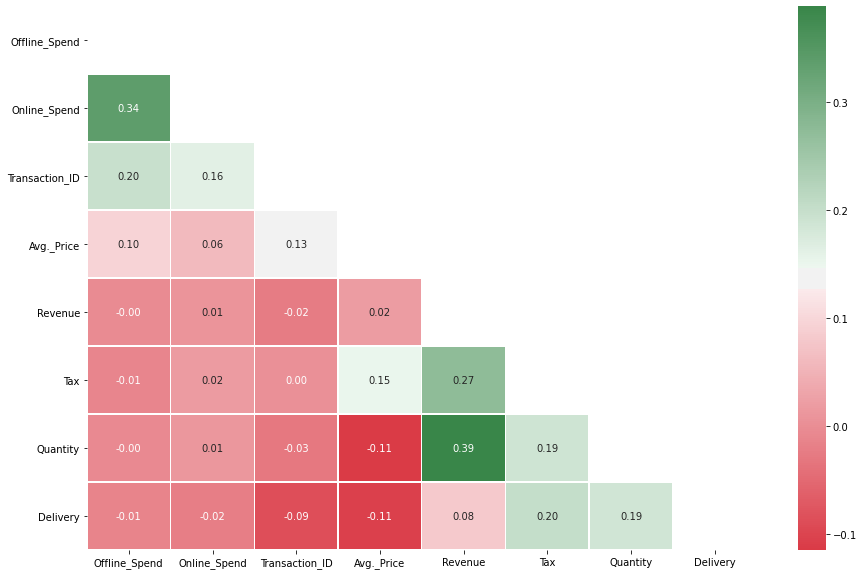

In [27]:
import seaborn as sns
df_correlation = df[['Date','Offline_Spend','Online_Spend','Transaction_ID','Product_SKU','Product','Product_Category_(Enhanced_E-commerce)',
 'Avg._Price','Revenue','Tax', 'Quantity','Delivery']]

upper_triangle = np.zeros_like(df_correlation.corr(), dtype = np.bool)
upper_triangle[np.triu_indices_from(upper_triangle)] = True #make sure we don't show half of the other triangle
f, ax = plt.subplots(figsize = (15, 10))
sns.heatmap(df_correlation.corr(),ax=ax,mask=upper_triangle,annot=True, fmt='.2f',linewidths=0.5,cmap=sns.diverging_palette(10, 133, as_cmap=True))

In [28]:
df1 = df.copy()
df1 = df1[['Date', 'Quantity']]
print("Shape:",df1.shape,"\n")
print(df1.info(),"\n")
print("Missing values:\n",df1.isnull().sum())
print("\nDescription:\n", df1.describe())

Shape: (54144, 2) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54144 entries, 0 to 54143
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      54144 non-null  datetime64[ns]
 1   Quantity  54144 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.2 MB
None 

Missing values:
 Date        0
Quantity    0
dtype: int64

Description:
            Quantity
count  54144.000000
mean       4.555648
std       20.179663
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max      900.000000


We group by "Date" and sum up the "Quantities"

In [29]:
df1 = df1.groupby(['Date'])['Quantity'].sum().reset_index()
df1.head(5)

,Date,Quantity
0,2017-01-01,399.0
1,2017-01-02,265.0
2,2017-01-03,823.0
3,2017-01-04,621.0
4,2017-01-05,2683.0


Let us integrate national holidays from UK in out dataset and will have a bad impact on our forcasted values. Let us first filter it out.

In [30]:
# holidays
uk_holidays = []
for date in holidays.UnitedKingdom(years = 2017).items():
    uk_holidays.append(str(date[0]))

holidays = pd.DataFrame(uk_holidays, columns=['Holiday Date']) 
holidays.head()

,Holiday Date
0,2017-01-01
1,2017-01-02
2,2017-01-03
3,2017-03-17
4,2017-04-14


In [31]:
df1['Holidays'] = df1['Date'].isin(uk_holidays)
df1.head()

,Date,Quantity,Holidays
0,2017-01-01,399.0,True
1,2017-01-02,265.0,True
2,2017-01-03,823.0,True
3,2017-01-04,621.0,False
4,2017-01-05,2683.0,False


In [32]:
# removing the holidays
df1 = df1[df1["Holidays"]==False]
df1.head()

,Date,Quantity,Holidays
3,2017-01-04,621.0,False
4,2017-01-05,2683.0,False
5,2017-01-06,1324.0,False
6,2017-01-07,105.0,False
7,2017-01-08,384.0,False


In [33]:
df2 = df1[["Date","Quantity"]]
df2.head()

,Date,Quantity
3,2017-01-04,621.0
4,2017-01-05,2683.0
5,2017-01-06,1324.0
6,2017-01-07,105.0
7,2017-01-08,384.0


In [34]:
# creating testing data for 2018 Jan month
date_2018 = "2018-01-01"
# index = pd.date_range(date_2018, periods=30, freq='D')
#creating Quantity column
# columns = ['Quantity']
test = pd.DataFrame()
test['Date'] = pd.date_range(start=date_2018, periods=30, freq='D')
# # extracting more features from the train dataset
test['Year'] = pd.to_datetime(test['Date']).dt.year
test['Week'] = pd.to_datetime(test['Date']).dt.week
test['Day'] = pd.to_datetime(test['Date']).dt.day
test['Weekday'] = pd.to_datetime(test['Date']).dt.dayofweek

test["Quantity"] = ""
test.head(8)

,Date,Year,Week,Day,Weekday,Quantity
0,2018-01-01,2018,1,1,0,
1,2018-01-02,2018,1,2,1,
2,2018-01-03,2018,1,3,2,
3,2018-01-04,2018,1,4,3,
4,2018-01-05,2018,1,5,4,
5,2018-01-06,2018,1,6,5,
6,2018-01-07,2018,1,7,6,
7,2018-01-08,2018,2,8,0,


In [35]:
# extracting more features from the train dataset
df2['Year'] = pd.to_datetime(df2['Date']).dt.year
df2['Week'] = pd.to_datetime(df2['Date']).dt.week
df2['Day'] = pd.to_datetime(df2['Date']).dt.day
df2['Weekday'] = pd.to_datetime(df2['Date']).dt.dayofweek
df2.head(8)

,Date,Quantity,Year,Week,Day,Weekday
3,2017-01-04,621.0,2017,1,4,2
4,2017-01-05,2683.0,2017,1,5,3
5,2017-01-06,1324.0,2017,1,6,4
6,2017-01-07,105.0,2017,1,7,5
7,2017-01-08,384.0,2017,1,8,6
8,2017-01-09,1011.0,2017,2,9,0
9,2017-01-10,1121.0,2017,2,10,1
10,2017-01-11,523.0,2017,2,11,2


Before running the model lets do EDA

In [36]:
df2.describe()


,Quantity,Year,Week,Day,Weekday
count,351.000000,351.0,351.000000,351.000000,351.000000
mean,679.686610,2017.0,26.538462,15.743590,3.068376
std,597.398861,0.0,14.952041,8.724174,1.985921
min,38.000000,2017.0,1.000000,1.000000,0.000000
25%,280.000000,2017.0,13.500000,8.000000,1.000000
50%,576.000000,2017.0,27.000000,16.000000,3.000000
75%,892.500000,2017.0,39.500000,23.000000,5.000000
max,5987.000000,2017.0,52.000000,31.000000,6.000000


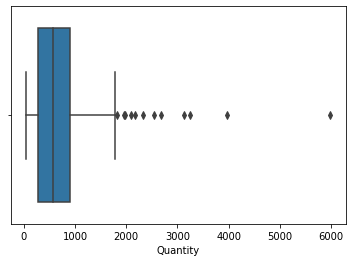

In [37]:
sns.boxplot(x=df2['Quantity'])

Lets plot some weekly

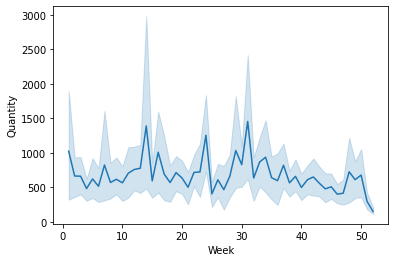

In [38]:
# weekly trend
sns.lineplot(df2['Week'], df2['Quantity'])

# Removing outliers

In [39]:
# removing outliers
df2 = df2[df2['Quantity']<3500]
df2.describe()


,Quantity,Year,Week,Day,Weekday
count,349.000000,349.0,349.000000,349.000000,349.000000
mean,655.028653,2017.0,26.561605,15.813754,3.074499
std,496.109130,0.0,14.977946,8.698807,1.989963
min,38.000000,2017.0,1.000000,1.000000,0.000000
25%,280.000000,2017.0,13.000000,8.000000,1.000000
50%,574.000000,2017.0,27.000000,16.000000,3.000000
75%,889.000000,2017.0,40.000000,23.000000,5.000000
max,3240.000000,2017.0,52.000000,31.000000,6.000000


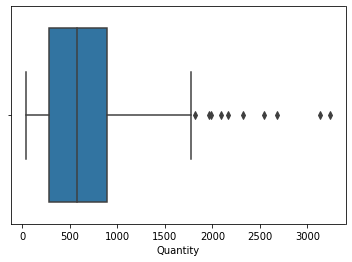

In [40]:
sns.boxplot(x=df2['Quantity'])

# Running the Random-Forest-Regressor
Before running the Random forest regressor let us evaluate wheather there are better algorithms for the dataset

In [41]:
df2

,Date,Quantity,Year,Week,Day,Weekday
3,2017-01-04,621.0,2017,1,4,2
4,2017-01-05,2683.0,2017,1,5,3
5,2017-01-06,1324.0,2017,1,6,4
6,2017-01-07,105.0,2017,1,7,5
7,2017-01-08,384.0,2017,1,8,6
...,...,...,...,...,...,...
360,2017-12-27,280.0,2017,52,27,2
361,2017-12-28,114.0,2017,52,28,3
362,2017-12-29,121.0,2017,52,29,4
363,2017-12-30,121.0,2017,52,30,5


# Splitting the dataset

In [42]:
#Breaking the data and selecting features , predictors
from sklearn.model_selection import train_test_split
predictors=df2.drop(['Quantity','Date'],axis=1)
target=df2['Quantity']
x_train,x_cv,y_train,y_cv=train_test_split(predictors,target,test_size=0.1,random_state=7)

# x_train -> Year, Week, Day, Weekday ...... shape(314*4)
# x_cv Year, Week, Day, Weekday ...... shape(35*4)
# y_train -> quantity ......... shape(314,)
# y_cv -> qunatity ........... shape(35,)

In [43]:
#Comparing Algorithms
def scores(i):
    lin = i()
    lin.fit(x_train, y_train)
    y_pred=lin.predict(x_cv)
    lin_r= r2_score(y_cv, y_pred)
    s.append(lin_r)
#Checking the scores by using our function
algos=[LinearRegression,KNeighborsRegressor,RandomForestRegressor,Lasso,ElasticNet,DecisionTreeRegressor]
s=[]
for i in algos:
    scores(i)

In [44]:
#Checking the score
models = pd.DataFrame({
    'Models': ['LinearRegression', 'KNeighborsRegressor', 
              'RandomForestRegressor', 'Lasso','DecisionTreeRegressor'],
    'R2-Score': [s[0],s[1],s[2],s[3],s[4]]})
models.sort_values(by='R2-Score', ascending=False)

,Models,R2-Score
0,LinearRegression,0.318481
3,Lasso,0.318292
4,DecisionTreeRegressor,0.307833
2,RandomForestRegressor,0.253139
1,KNeighborsRegressor,-0.103524


As we can see Linear regression will give the best R squared score for our dataset.
As we have evaluated, let's run for Random Forest Regressor and see how it performs.

In [45]:
#Hypertuned Model
model = RandomForestRegressor()
# bootstrap=True, criterion='mse', max_depth=None,
#                       max_features='auto', max_leaf_nodes=None,
#                       min_impurity_decrease=0.0, min_impurity_split=None,
#                       min_samples_leaf=4, min_samples_split=2,
#                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=3,
#                       oob_score=True, random_state=7, verbose=0,
#                       warm_start=False



model.fit(x_train,y_train)

RandomForestRegressor()

In [46]:
pred = model.predict(x_cv)
# R2 Score
r2_score(pred, y_cv)

-0.26323232493450366

In [47]:
def mean_percentage_error(y_cv, pred): 
    y_cv, pred = np.array(y_cv), np.array(pred)
    return np.mean(np.array((y_cv - pred) / y_cv)) * 100
mean_percentage_error(y_cv, pred)

-37.7704889726143

let's predict for the 2018 Jan dataset, we have created earlier

In [48]:
test1=test.drop(['Quantity', 'Date'],axis=1)
pred2=model.predict(test1)
test['Quantity']=pred2.round(0)
test.head()

,Date,Year,Week,Day,Weekday,Quantity
0,2018-01-01,2018,1,1,0,1164.0
1,2018-01-02,2018,1,2,1,1151.0
2,2018-01-03,2018,1,3,2,1130.0
3,2018-01-04,2018,1,4,3,1342.0
4,2018-01-05,2018,1,5,4,1882.0


In [50]:
result=test[['Date','Quantity']]
result

,Date,Quantity
0,2018-01-01,1164.0
1,2018-01-02,1151.0
2,2018-01-03,1130.0
3,2018-01-04,1342.0
4,2018-01-05,1882.0
5,2018-01-06,250.0
6,2018-01-07,288.0
7,2018-01-08,873.0
8,2018-01-09,1017.0
9,2018-01-10,945.0
